In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from nest import overlap_try as overlap
from nest import detectors   
from astropy.cosmology import Planck18
from nest import pls_try as pls
import matplotlib.cm as cm
from scipy.integrate import simps

cosmo = Planck18
H0 =  cosmo.H0.to('1/s').value

plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.family'] = 'serif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


PLS definition

In [19]:
# def S eff

def Seff(f, fref, snr, Tobs, orf, Ni, Nj):
    return np.sqrt(Ni*Nj)/orf

def Omega_eff(f, fref, snr, Tobs, orf, Ni, Nj):
    return 10* np.pi**2 /(3* H0**2)* f**3 * Seff(f, fref, snr, Tobs, orf, Ni, Nj)
    
def Omega_beta(f, fref, snr, Tobs, beta, orf, Ni, Nj):
    Tobs = Tobs * 365 * 24 * 3600
    Omega_eff_num = Omega_eff(f, fref, snr, Tobs, orf, Ni, Nj)
    integrand = (((f/fref)**(beta)) / (Omega_eff_num))**2
    integral = simps(integrand, f)
    return  snr /np.sqrt(2*Tobs)/np.sqrt(integral)

def Omega_GW(f, fref, snr, Tobs, beta, orf, Ni, Nj):
    return Omega_beta(f, fref, snr, Tobs, beta, orf, Ni, Nj) * ((f/fref)**(beta))

def all_Omega_GW(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj):
    beta = np.linspace(beta_min, beta_max, 1000)
    Omega = []
    for i in range(len(beta)):
        Omega.append(Omega_GW(f, fref, snr, Tobs, beta[i], orf, Ni, Nj))     
    return beta, np.array(Omega)

def PLS(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj):
    beta, Omega = all_Omega_GW(f, fref, snr, Tobs, beta_min, beta_max, orf, Ni, Nj)
    print(Omega.shape)
    pls = np.zeros(len(f))
    for i in range(len(f)):
        pls[i] = np.max(Omega[:,i])
    return pls



PSD

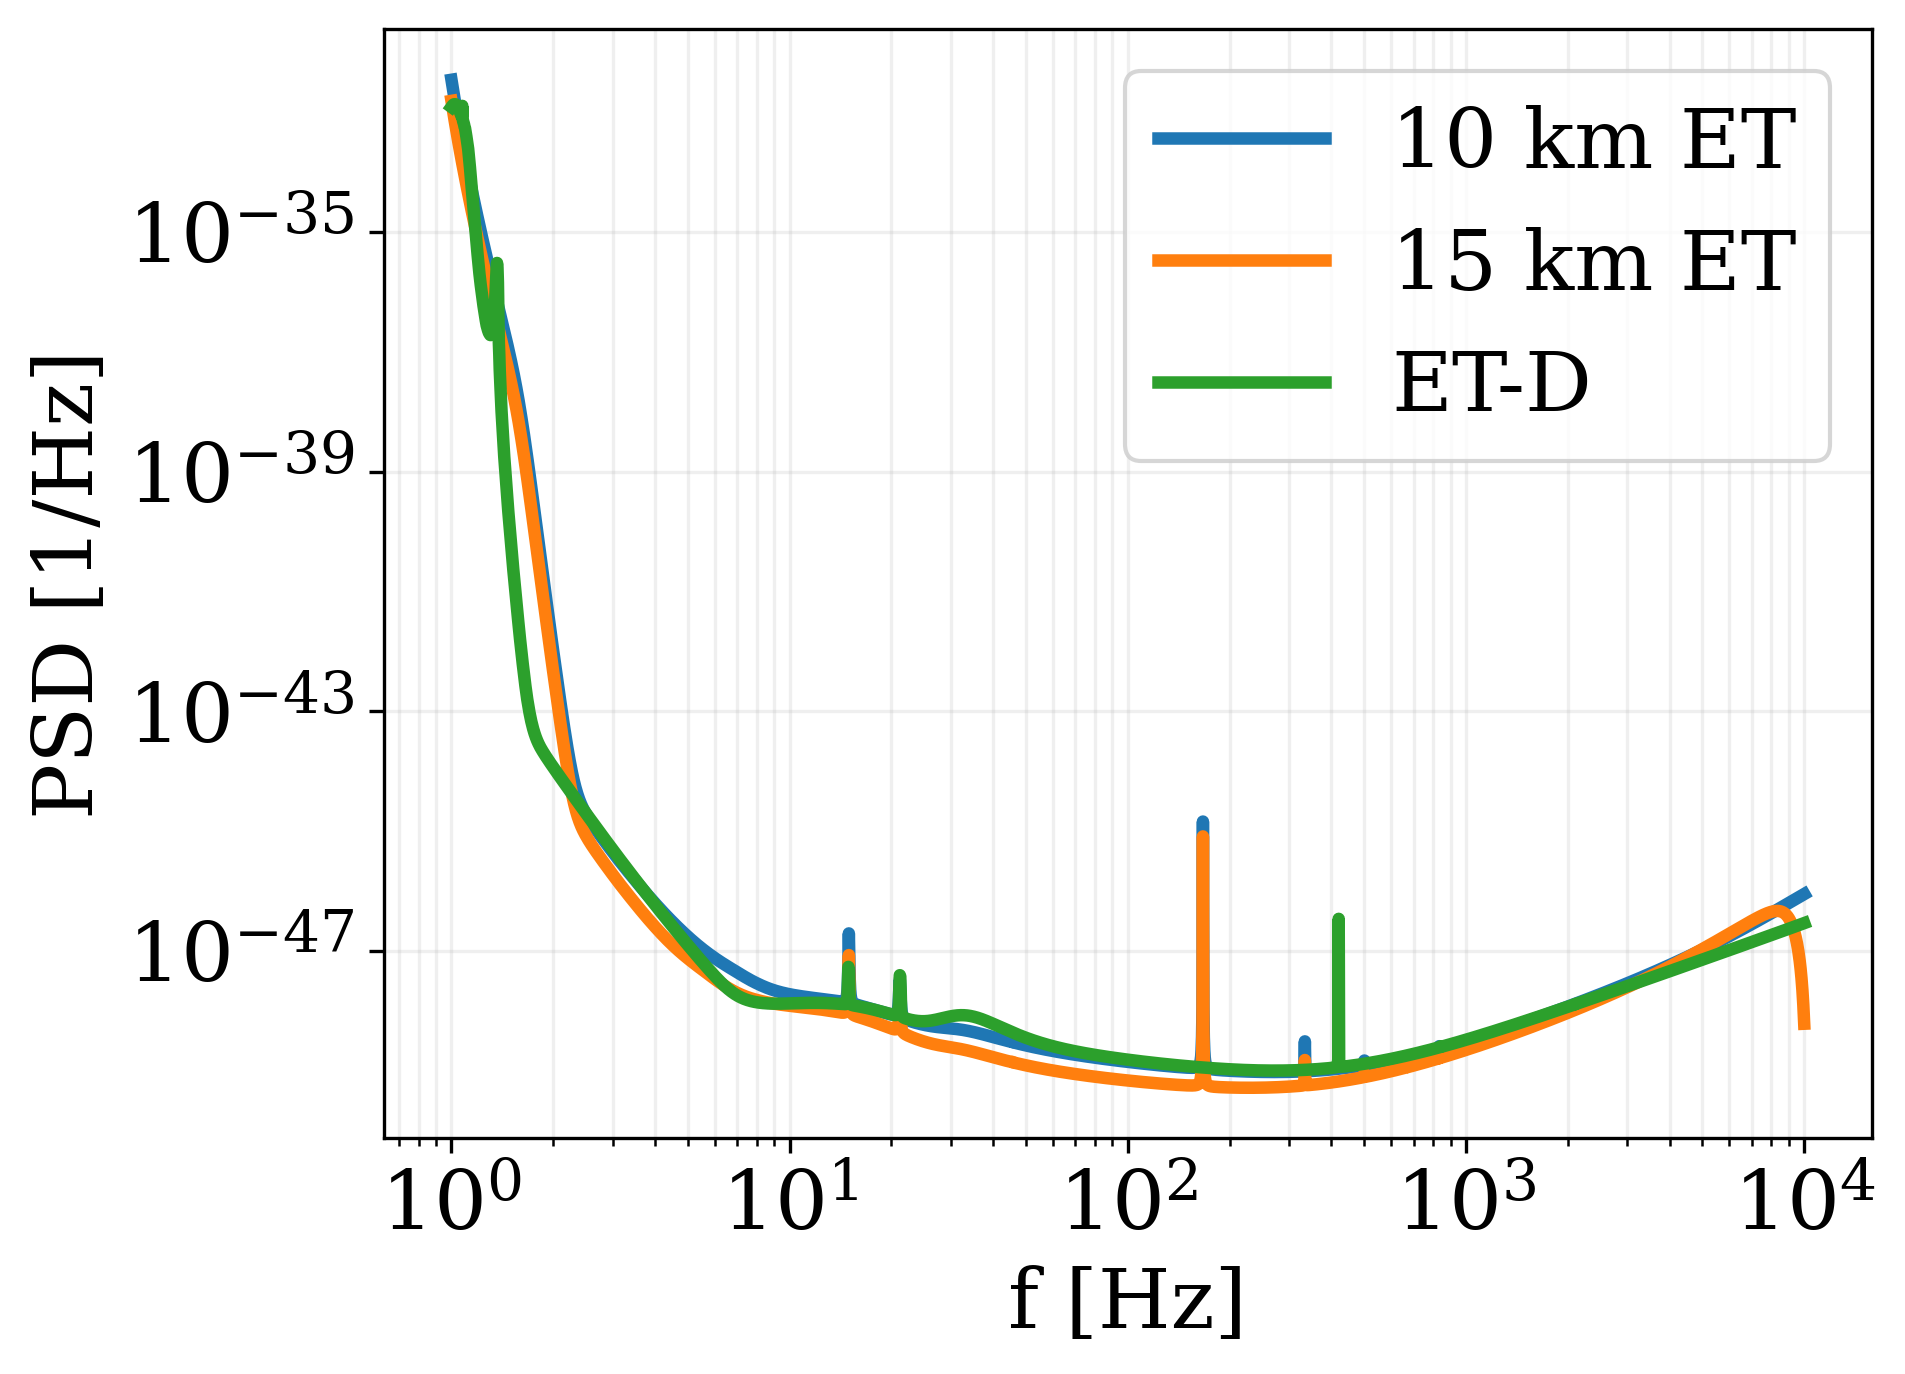

In [20]:
f_10km, psd_hf_10km, psd_lf_10km, psd_10km = np.loadtxt('psd/18213_ET10kmcolumns.txt', unpack=True)
f_15km, psd_hf_15km, psd_lf_15km, psd_15km = np.loadtxt('psd/18213_ET15kmcolumns.txt', unpack=True)
f_ETD, psd_ETD = np.loadtxt('psd/et_d.txt', unpack=True)

psd_ETD = psd_ETD **2

plt.plot(f_10km, psd_10km, label='10 km ET')
plt.plot(f_15km, psd_15km, label='15 km ET')
plt.plot(f_ETD, psd_ETD, label='ET-D')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('PSD [1/Hz]')
plt.grid(alpha=0.2, which='both')
plt.legend()
plt.show()



* ET $\Delta$

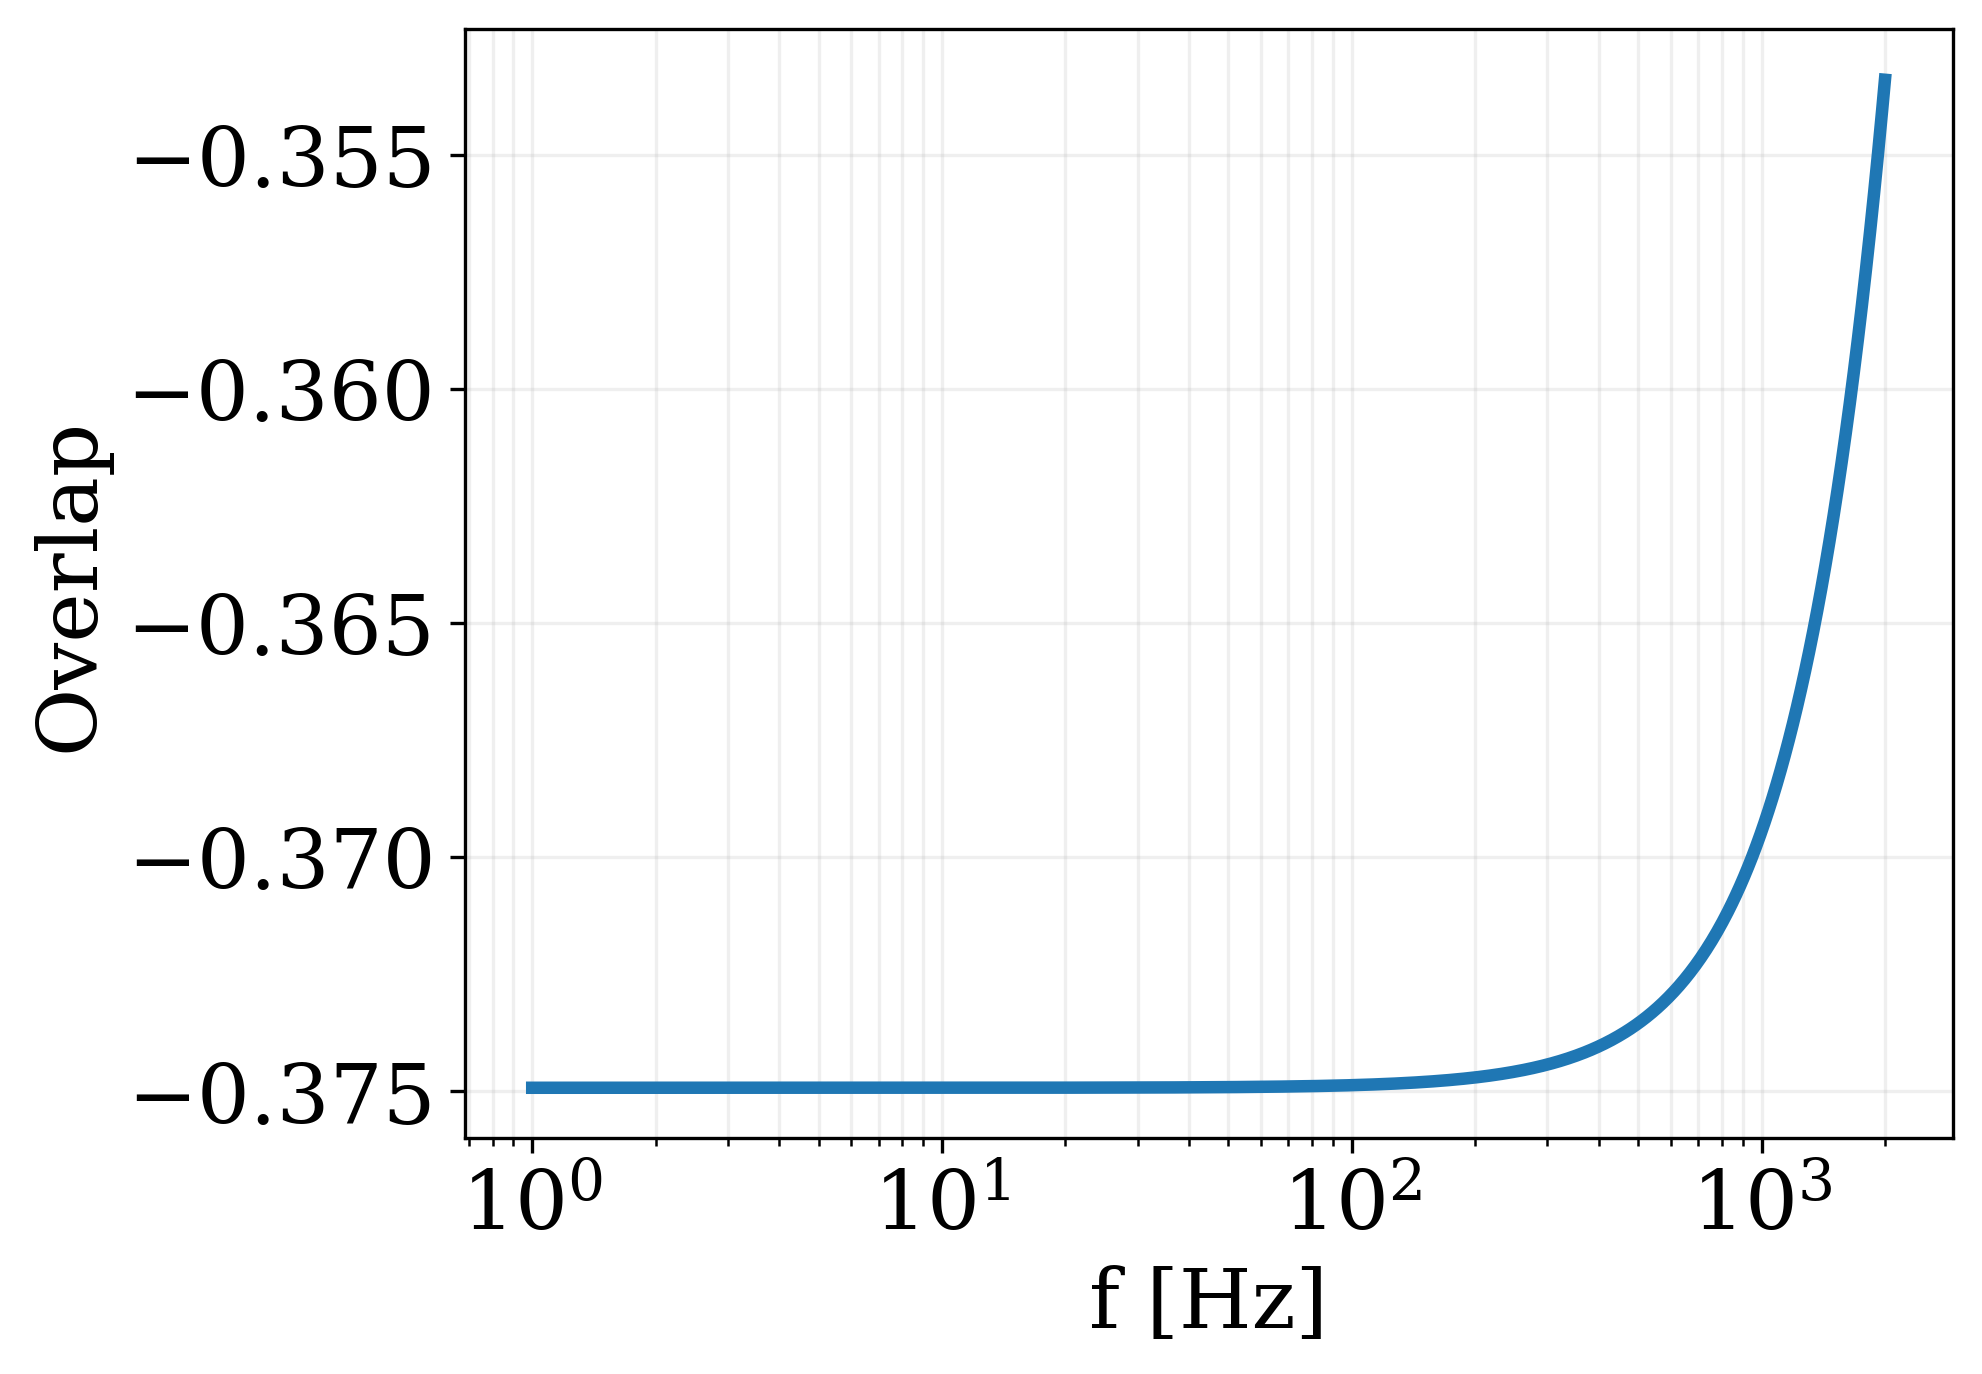

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_70928/1546655949.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(integrand, f)


(1000, 1000)


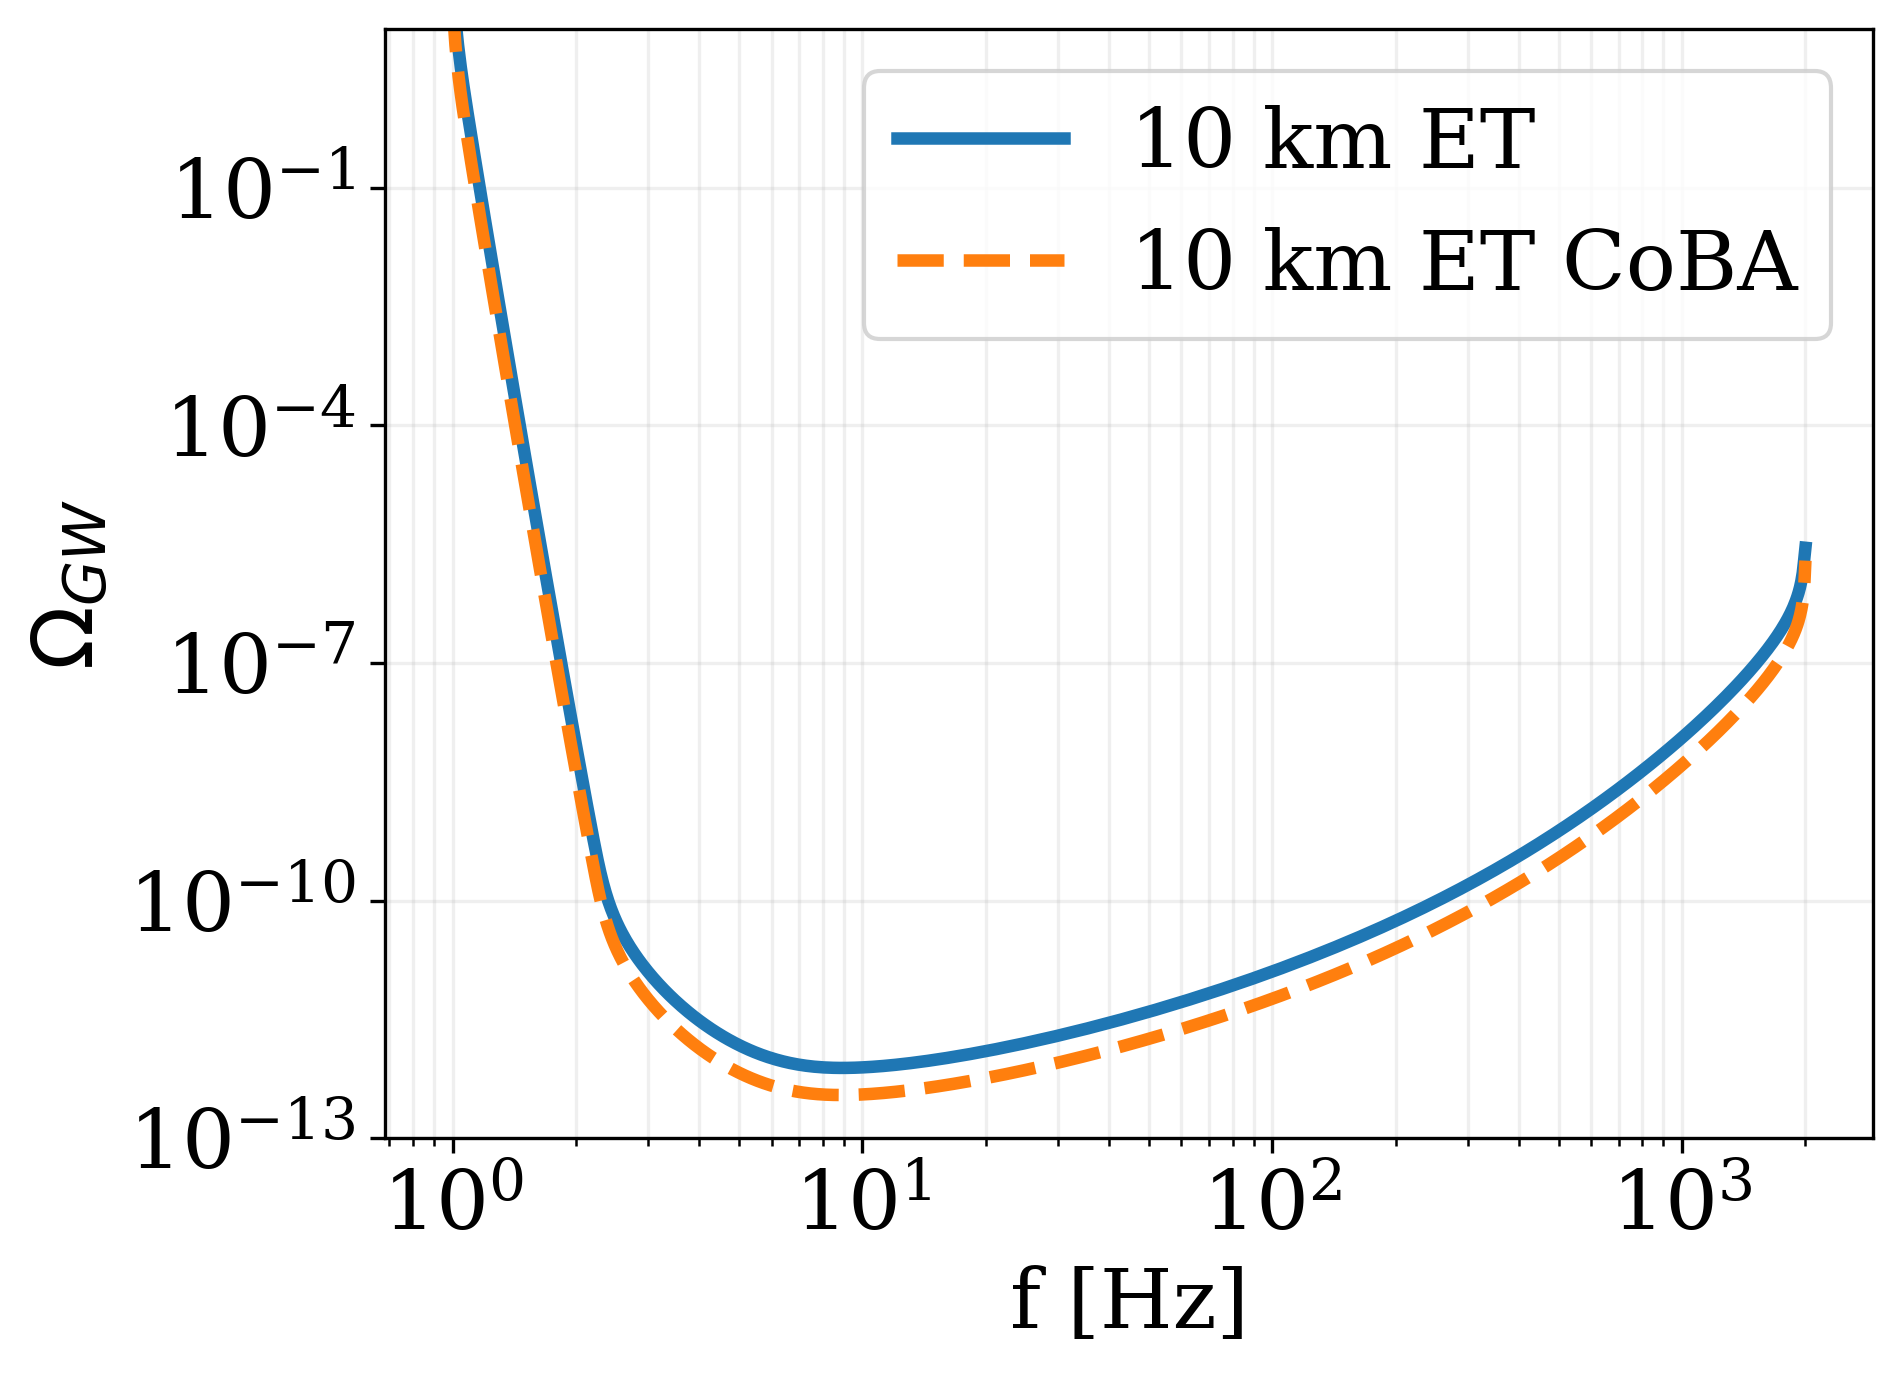

1.2025130293408584


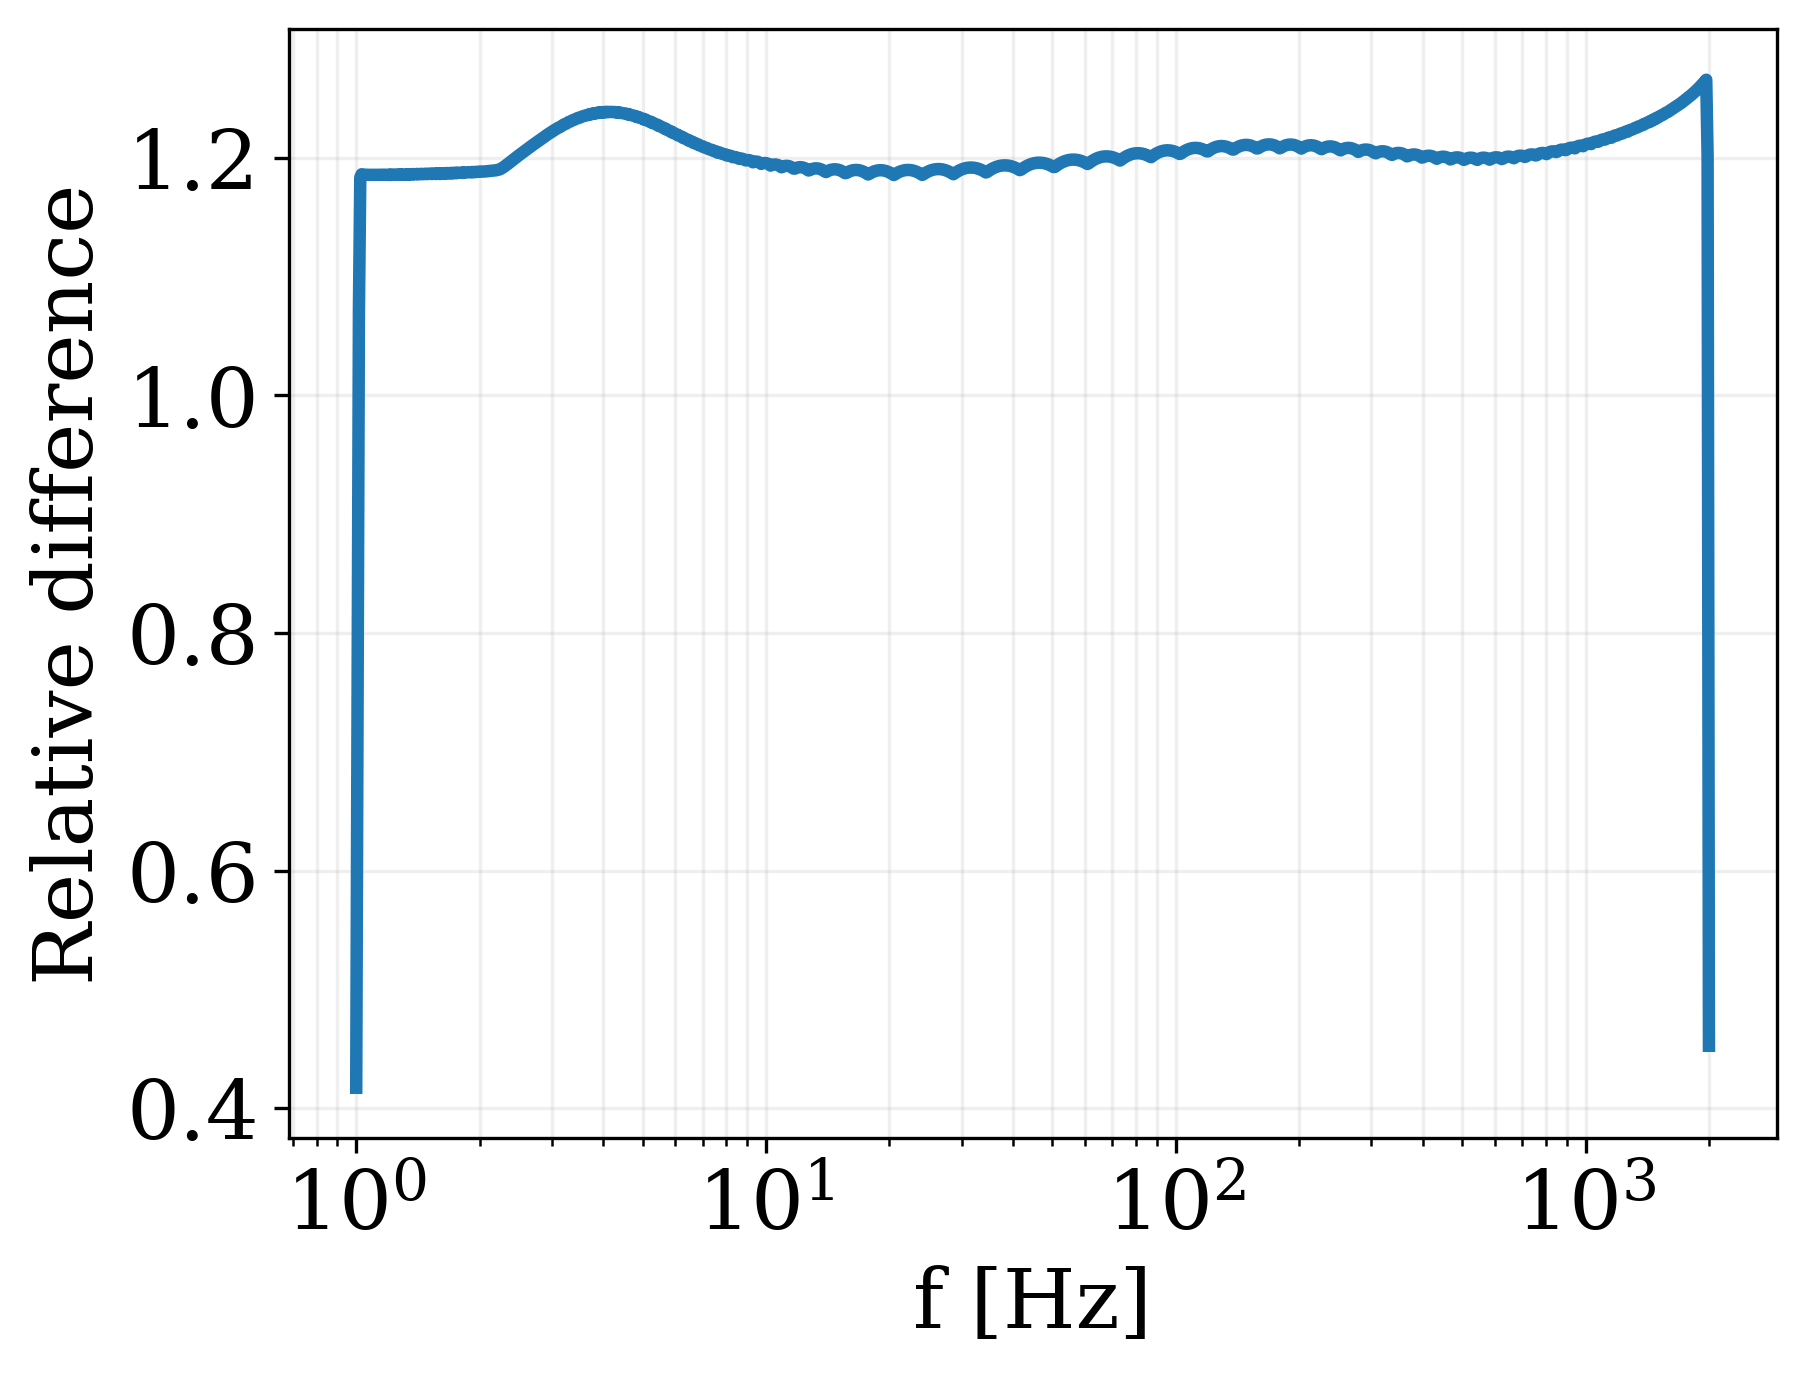

In [21]:
beta_min = -50
beta_max = 50
fref = 100
snr = 1
Tobs = 1

f = np.logspace(0, np.log10(2000), 1000)

orf_tr = overlap.overlap('ET A', 'ET B', f, 0, 't', None)

plt.plot(f, orf_tr)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap')
plt.grid(alpha=0.2, which='both')
plt.show()

Ni = np.interp(f, f_10km,psd_10km)
Nj = np.interp(f, f_10km,psd_10km)


pls_10km = PLS(f, fref, snr, Tobs, beta_min, beta_max, orf_tr, Ni, Nj)

f_pls_10km_coba, pls_10km_coba = np.loadtxt('PLS_CoBA_store/h2_Omega_PLS_SNR_1_Tobs_1yr_T_10km_HFLFcryo.txt', unpack=True)

plt.plot(f, pls_10km/(np.sqrt(3)), label='10 km ET')
plt.plot(f_pls_10km_coba, pls_10km_coba, label='10 km ET CoBA', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Omega_{GW}$')
plt.grid(alpha=0.2, which='both')
plt.ylim(1e-13, 1e1)
plt.legend()
plt.show()

pls_10km_coba = np.interp(f, f_pls_10km_coba, pls_10km_coba)
diff1 = (pls_10km/(np.sqrt(3)) - pls_10km_coba)/pls_10km_coba
print(np.mean(diff1))

plt.plot(f, diff1)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Relative difference')
plt.grid(alpha=0.2, which='both')
plt.show()



* ET 2L $\alpha = 0^{\circ}$

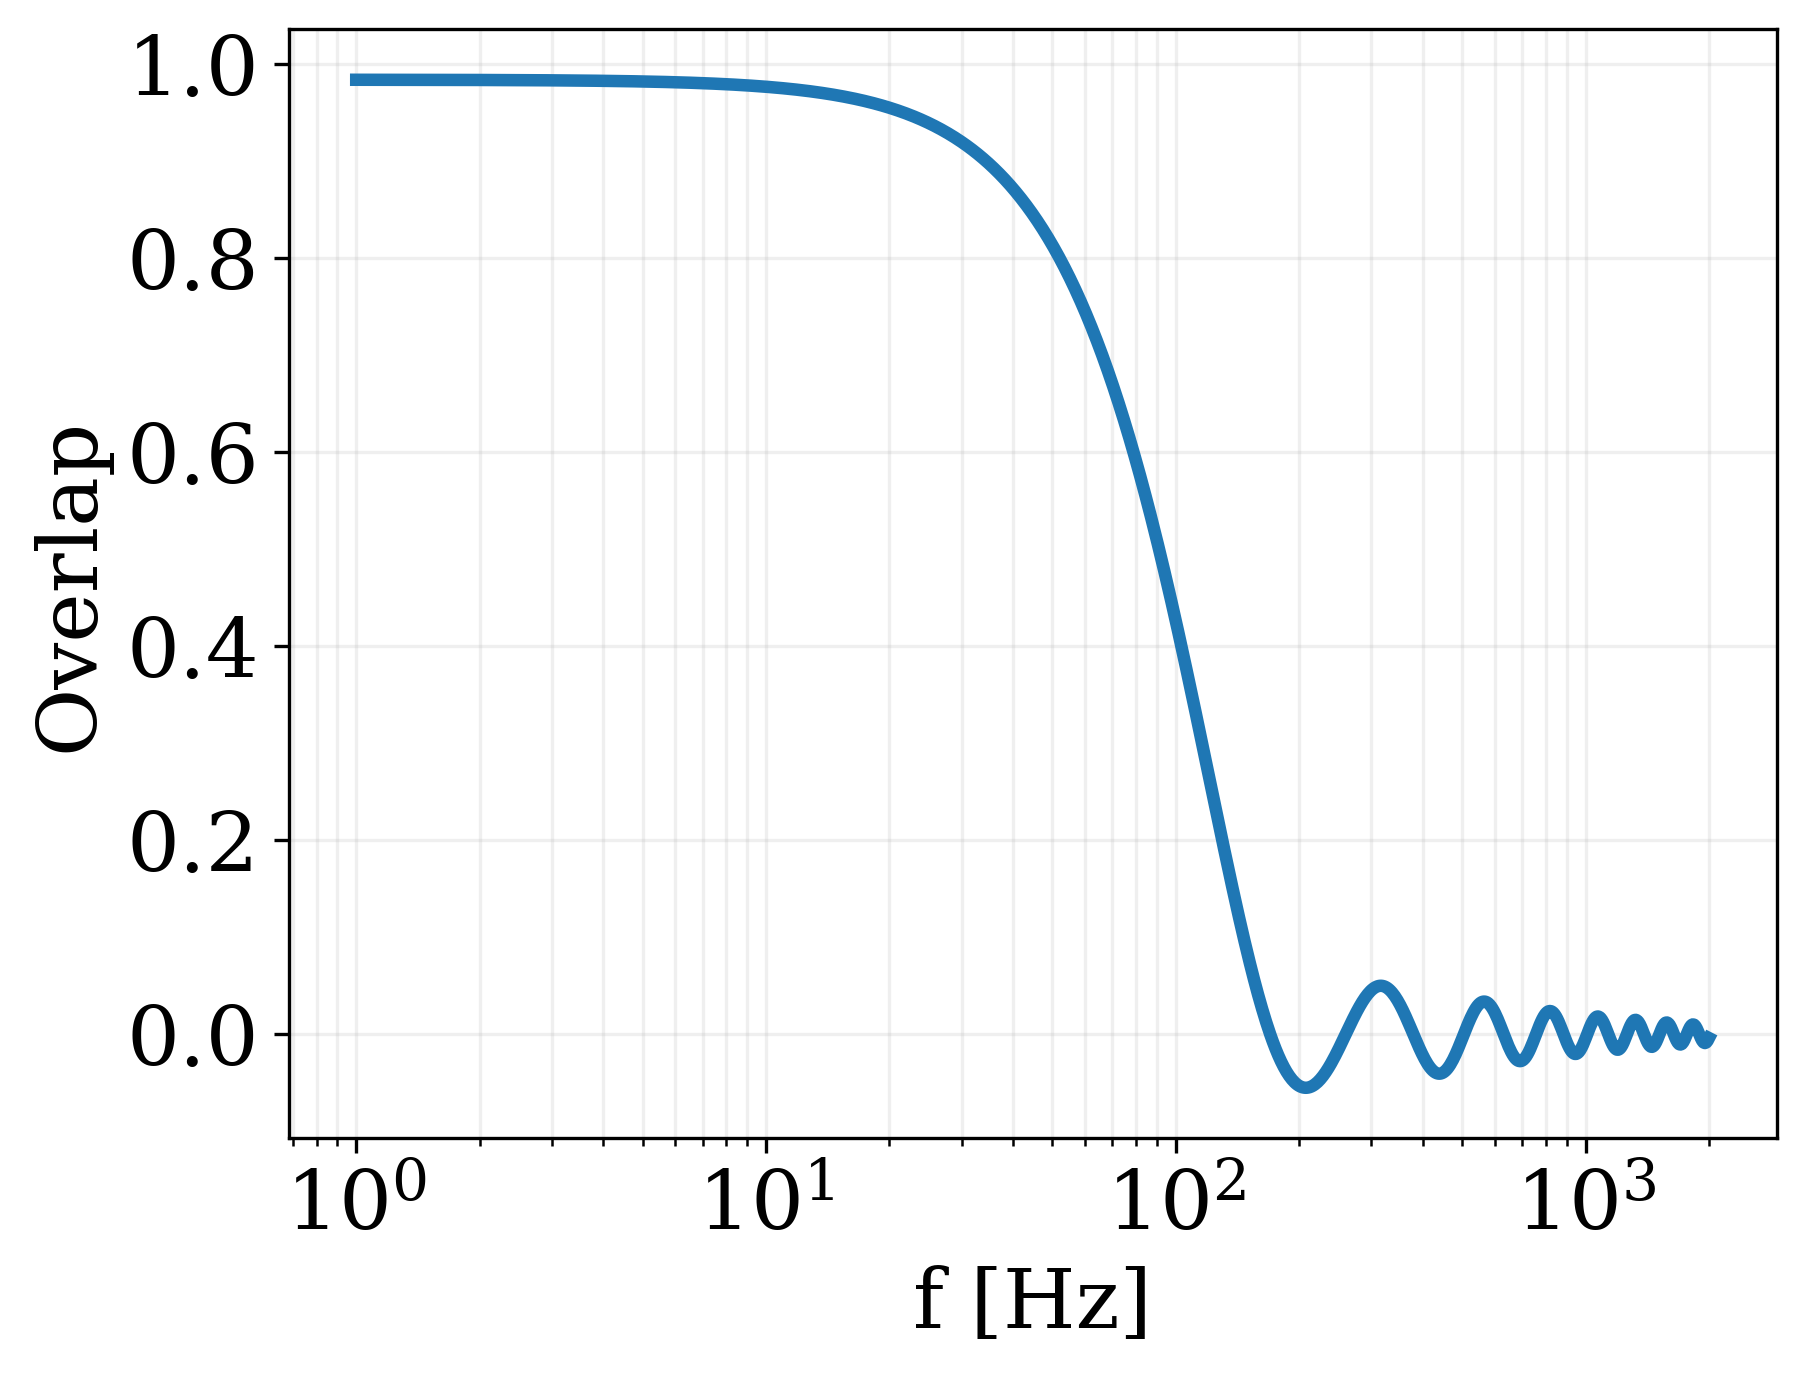

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_70928/1546655949.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(integrand, f)


(1000, 1000)


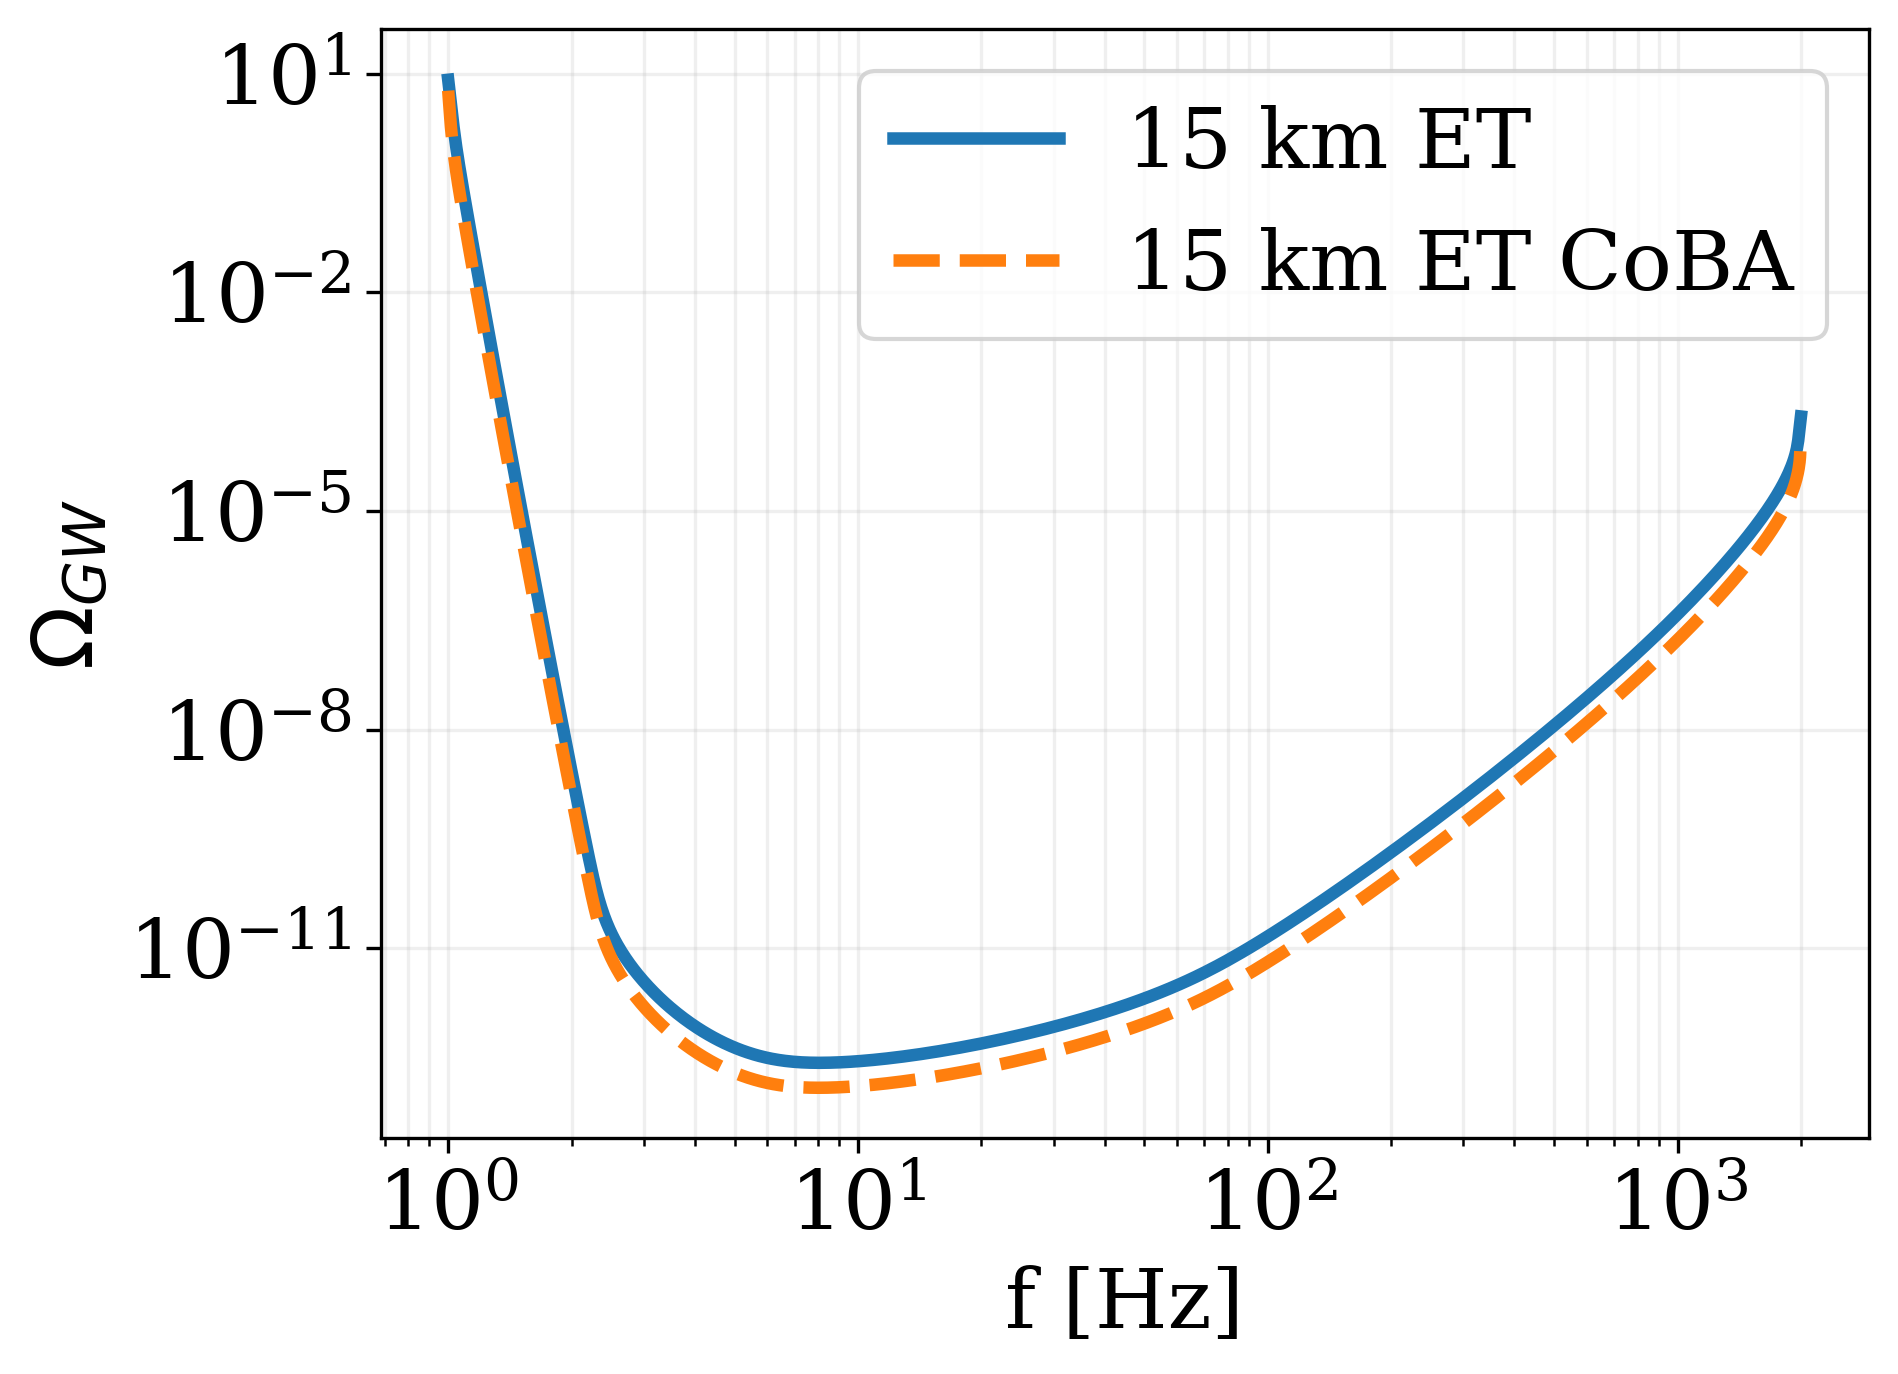

1.2189445416501734


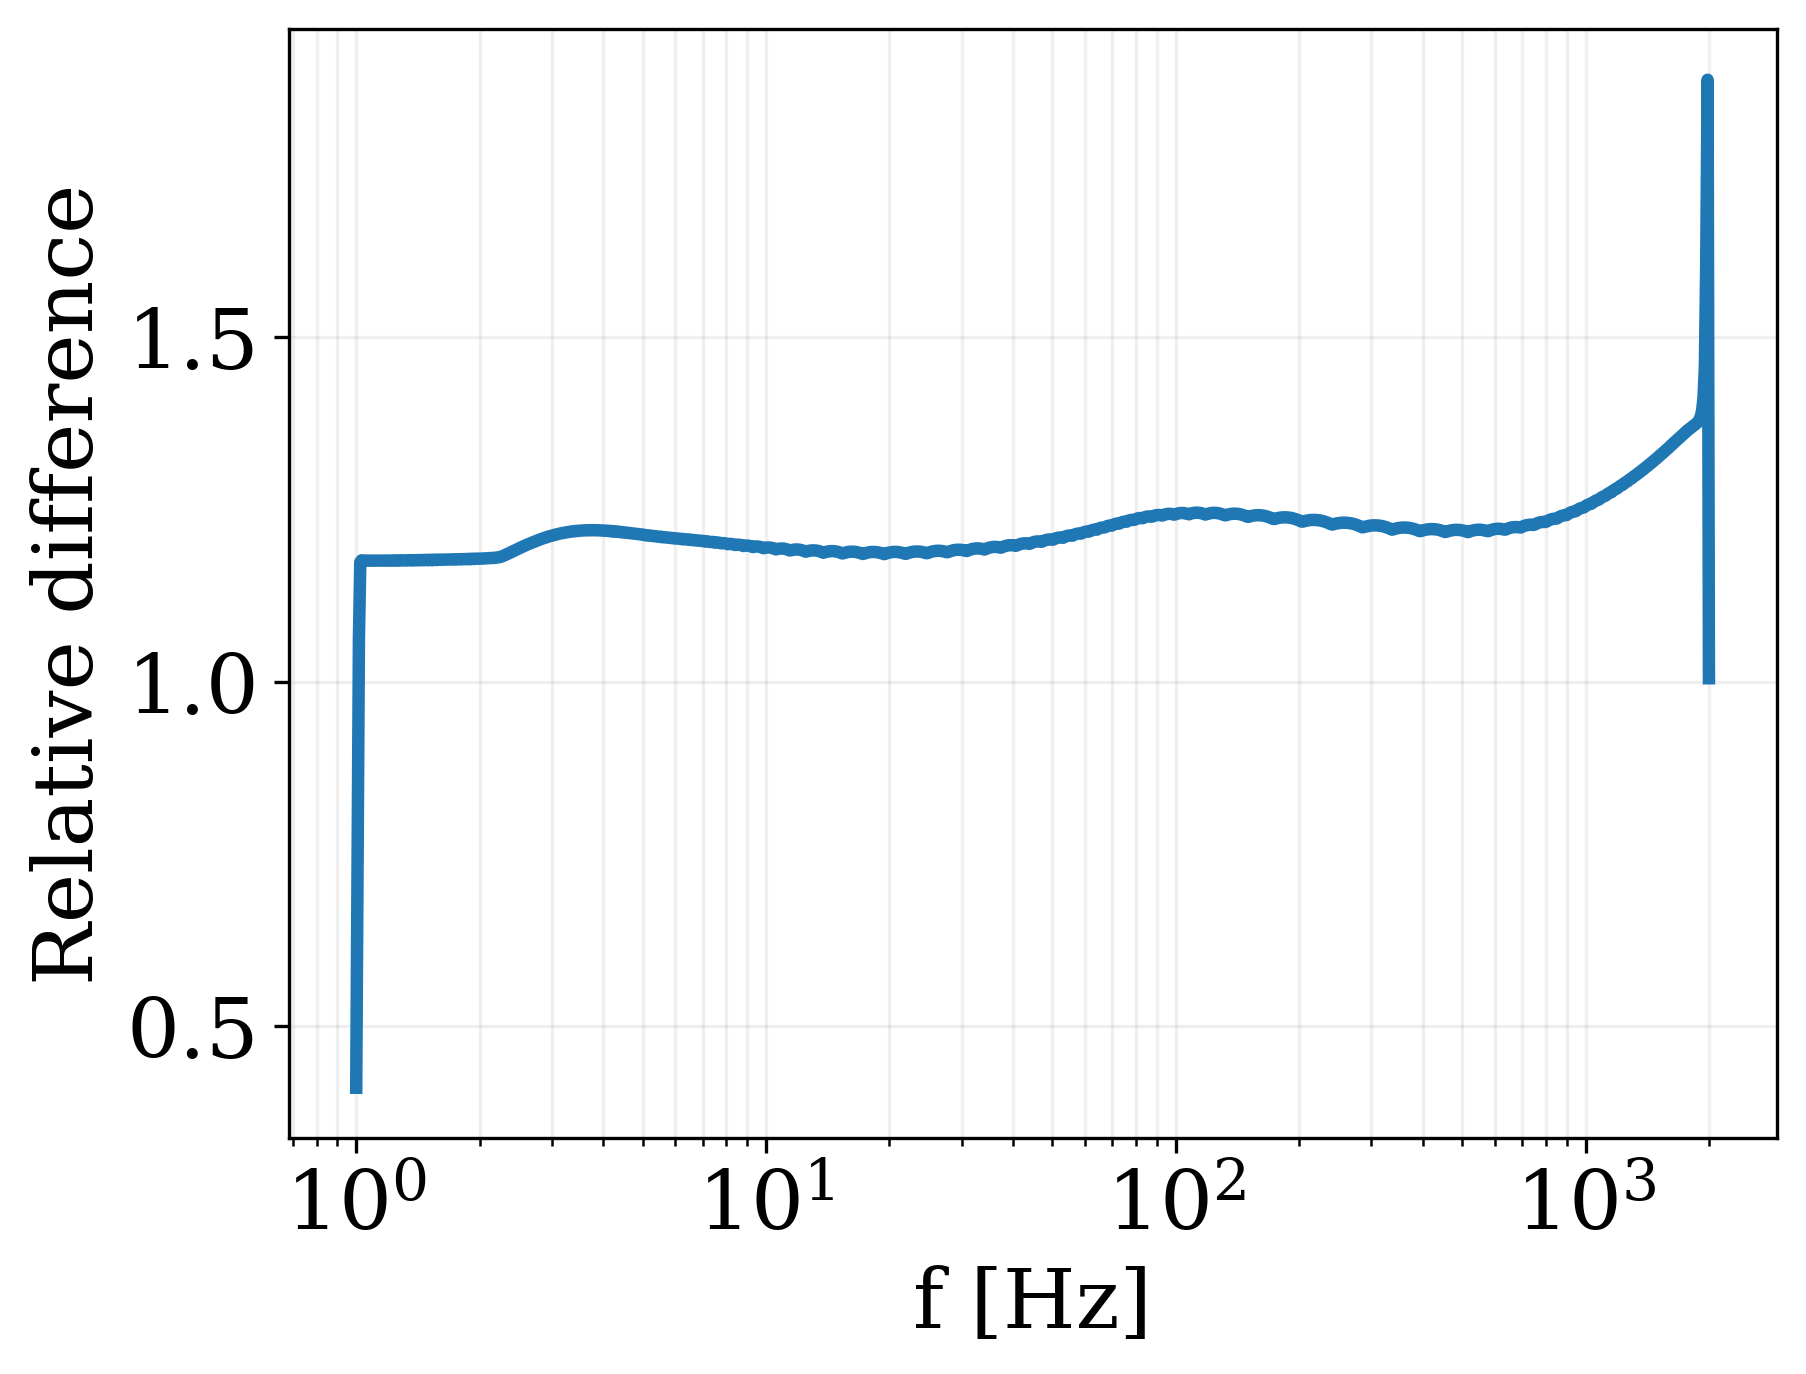

In [22]:
beta_min = -50
beta_max = 50
fref = 100
snr = 1
Tobs = 1

f = np.logspace(0, np.log10(2000), 1000)

orf_2L0 = overlap.overlap('ET L1', 'ET L2', f, 0, 't', np.deg2rad(0))

Ni = np.interp(f, f_15km,psd_15km)
Nj = np.interp(f, f_15km,psd_15km)

plt.plot(f, orf_2L0)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap')
plt.grid(alpha=0.2, which='both')
plt.show()

pls_15km = PLS(f, fref, snr, Tobs, beta_min, beta_max, orf_2L0, Ni, Nj)

f_pls_15km_coba, pls_15km_coba = np.loadtxt('PLS_CoBA_store/h2_Omega_PLS_SNR_1_Tobs_1yr_2L0deg_15km_HFLFcryo.txt', unpack=True)

plt.plot(f, pls_15km, label='15 km ET')
plt.plot(f_pls_15km_coba, pls_15km_coba, label='15 km ET CoBA', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Omega_{GW}$')
plt.grid(alpha=0.2, which='both')
plt.legend()
plt.show()

pls_15km_coba = np.interp(f, f_pls_15km_coba, pls_15km_coba)
diff2 = (pls_15km - pls_15km_coba)/pls_15km_coba

print(np.mean(diff2))

plt.plot(f, diff2)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Relative difference')
plt.grid(alpha=0.2, which='both')
plt.show()


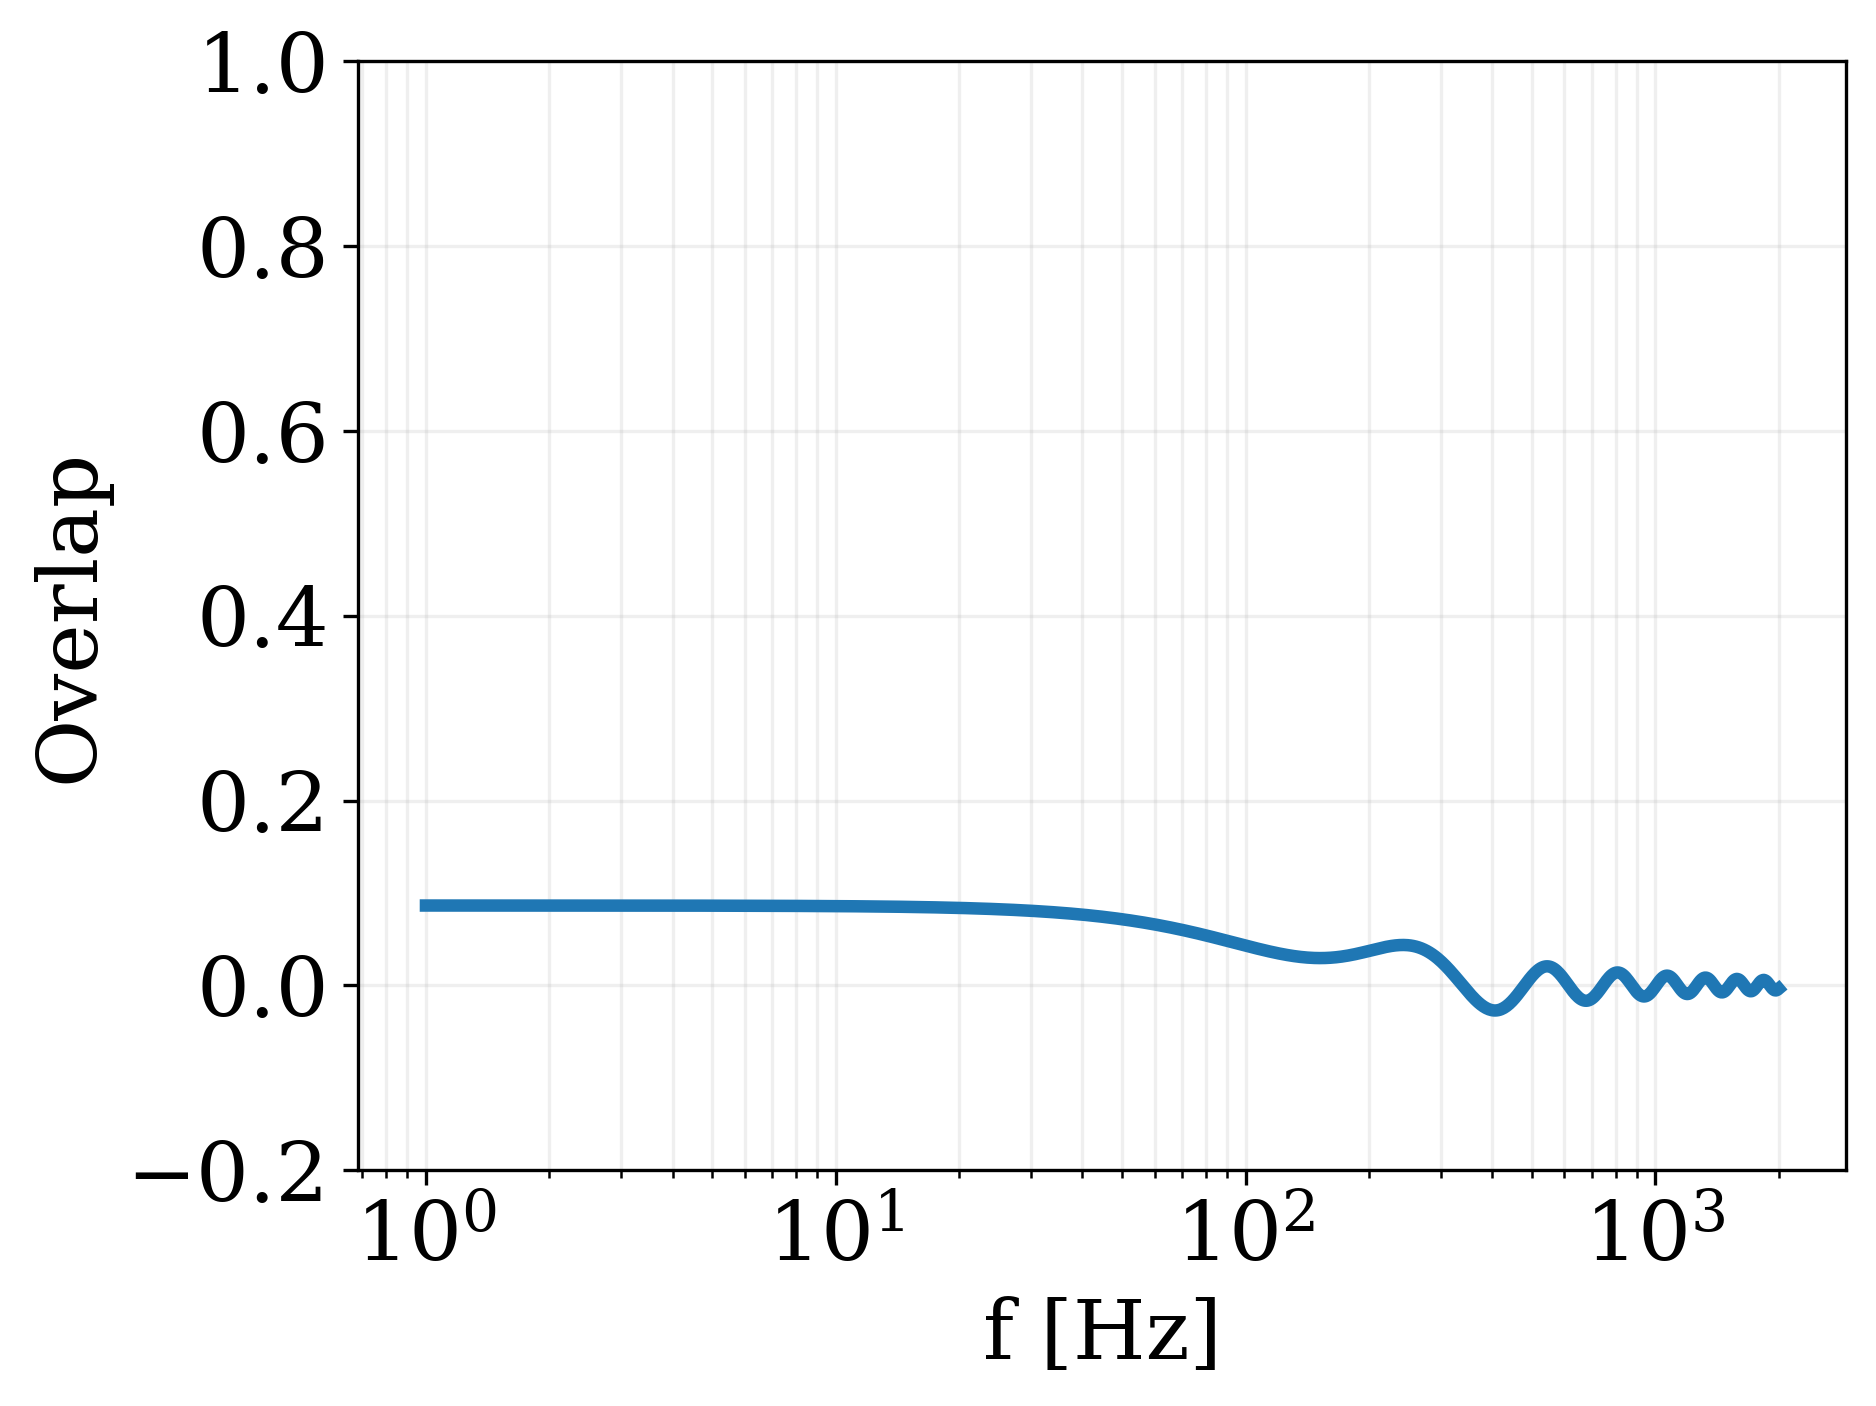

/var/folders/5d/ymf225n1541cfw2gc3hlv41w0000gn/T/ipykernel_70928/1546655949.py:13: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(integrand, f)


(1000, 1000)


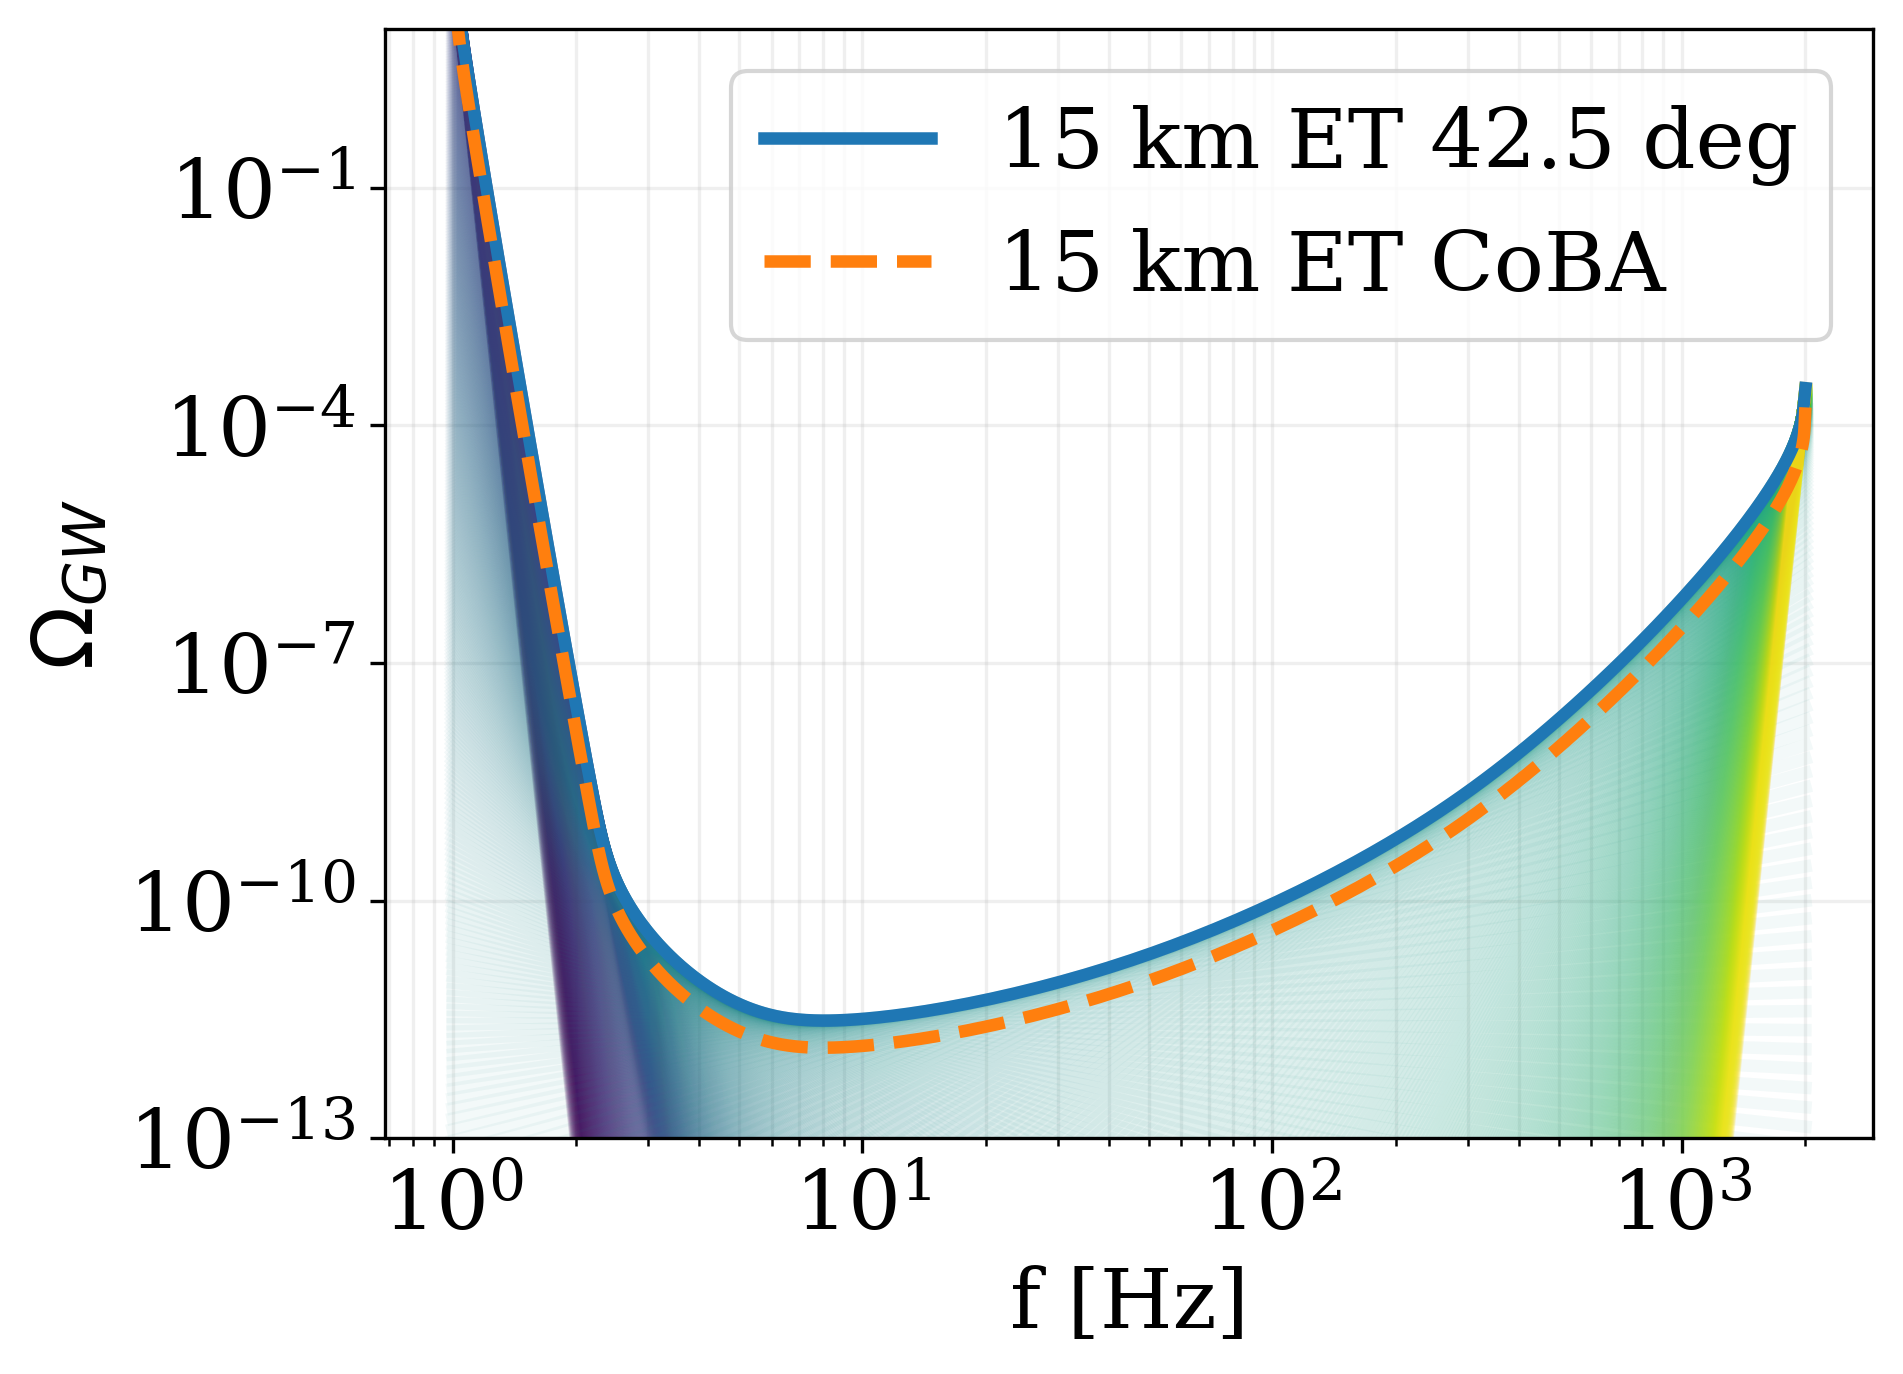

1.2099130910875961


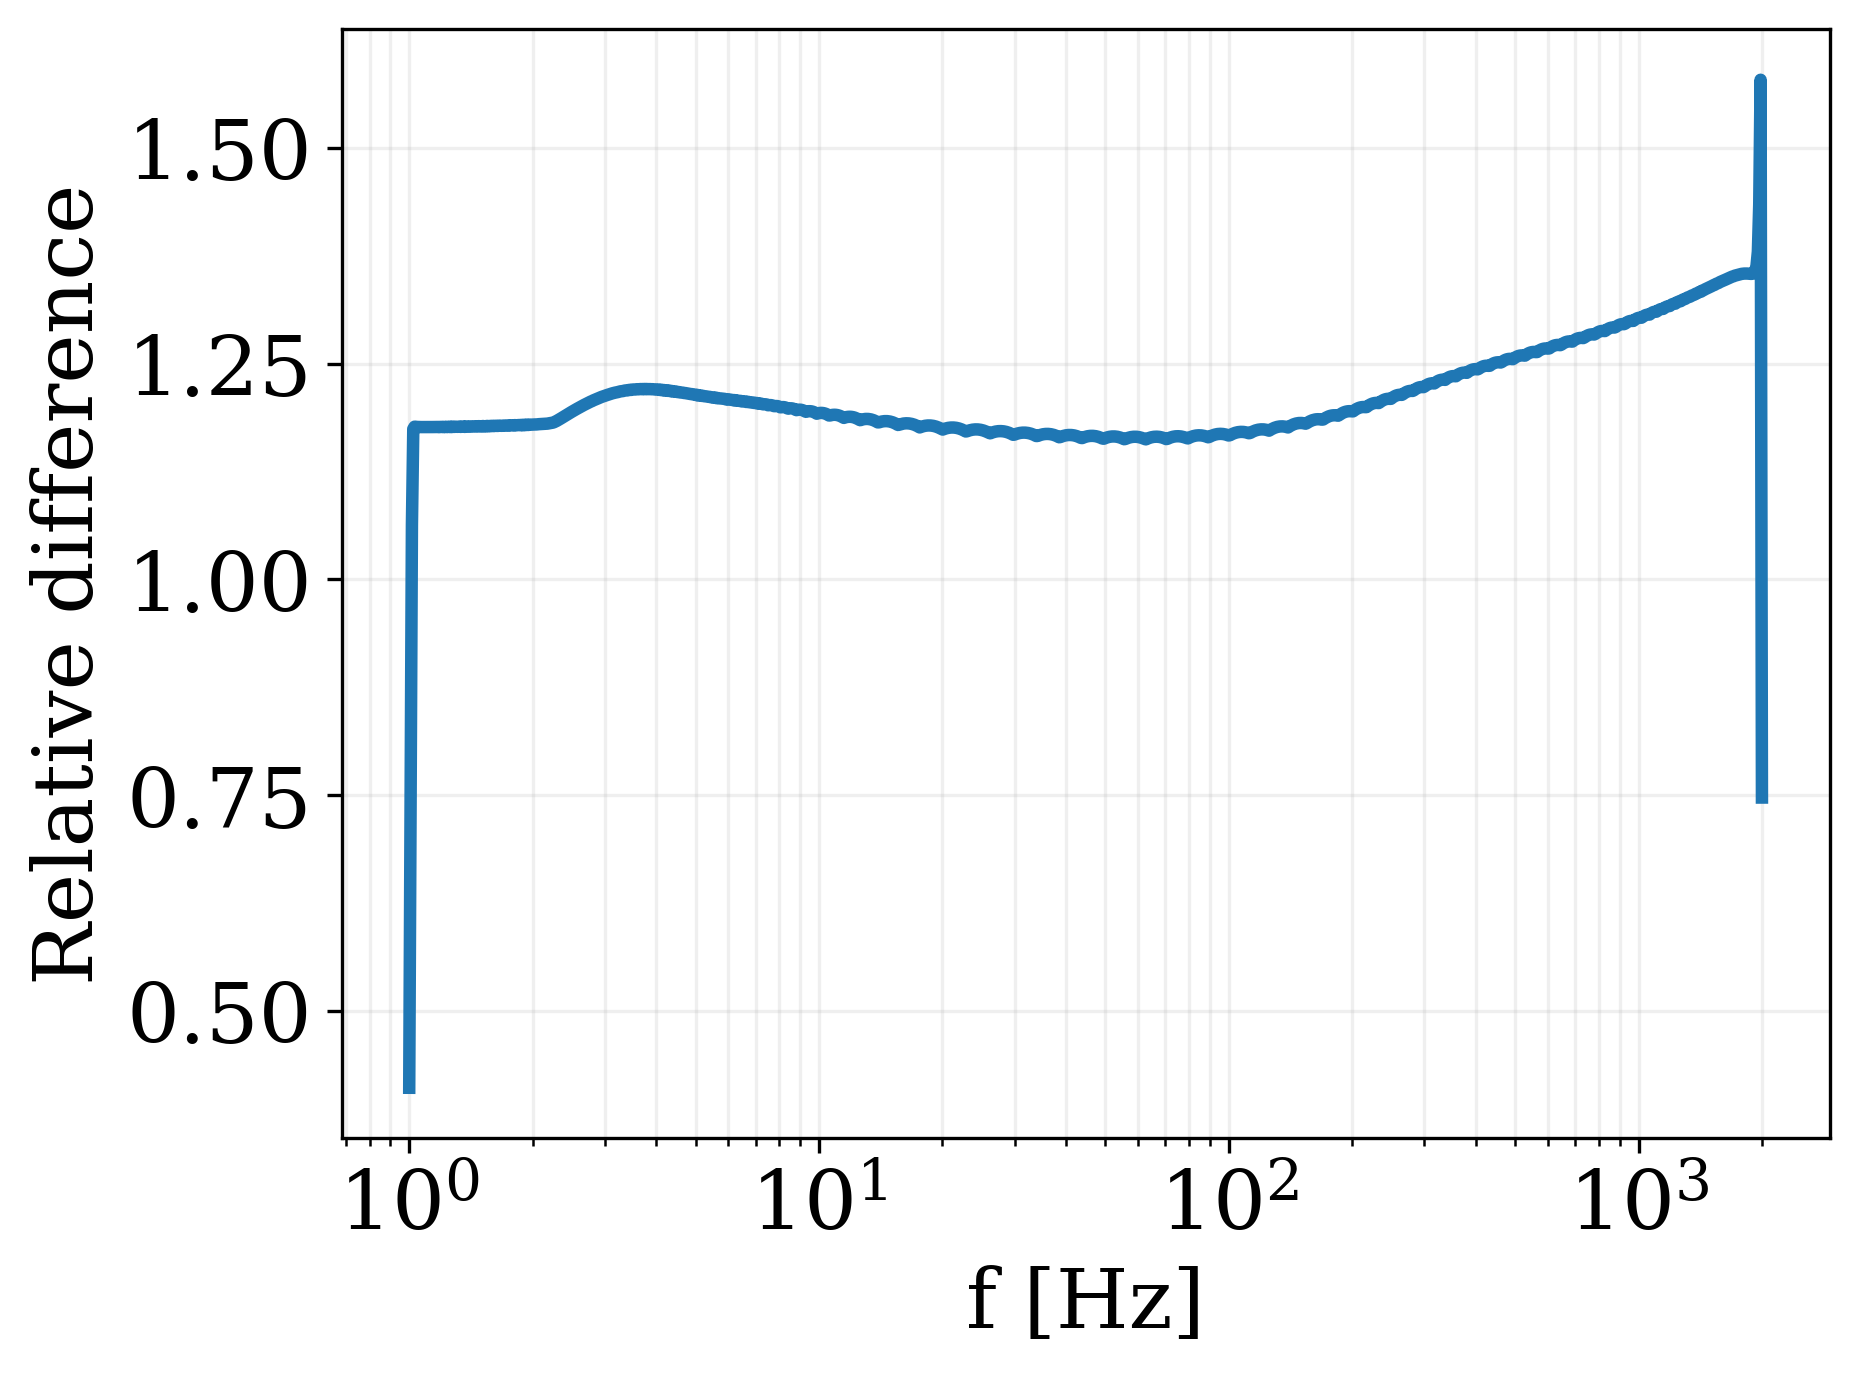

In [23]:
beta_min = -50
beta_max = 50
fref = 100
snr = 1
Tobs = 1

f = np.logspace(0, np.log10(2000), 1000)

orf_2L425 = overlap.overlap('ET L1', 'ET L2', f, 0, 't', np.deg2rad(42.5))

Ni = np.interp(f, f_15km,psd_15km)
Nj = np.interp(f, f_15km,psd_15km)

plt.plot(f, orf_2L425)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Overlap')
plt.grid(alpha=0.2, which='both')
plt.ylim(-0.2, 1)
plt.show()

beta, Omega = all_Omega_GW(f, fref, snr, Tobs, beta_min, beta_max, orf_2L425, Ni, Nj)

pls_15km = PLS(f, fref, snr, Tobs, beta_min, beta_max, orf_2L425, Ni, Nj)

f_pls_15km_coba, pls_15km_coba = np.loadtxt('PLS_CoBA_store/h2_Omega_PLS_SNR_1_Tobs_1yr_2L45deg_15km_HFLFcryo.txt', unpack=True)


for i in range(len(beta)):
    plt.plot(f, Omega[i], color=cm.viridis(i/len(beta)), alpha=0.05) 
plt.plot(f, pls_15km, label='15 km ET 42.5 deg')
plt.plot(f_pls_15km_coba, pls_15km_coba, label='15 km ET CoBA', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Omega_{GW}$')
plt.grid(alpha=0.2, which='both')
plt.ylim(1e-13, 1e1)
plt.legend()
plt.show()

pls_15km_coba = np.interp(f, f_pls_15km_coba, pls_15km_coba)
diff3 = (pls_15km - pls_15km_coba)/pls_15km_coba

print(np.mean(diff3))

plt.plot(f, diff3)
plt.xscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Relative difference')
plt.grid(alpha=0.2, which='both')
plt.show()


Plot relative difference in the three different cases

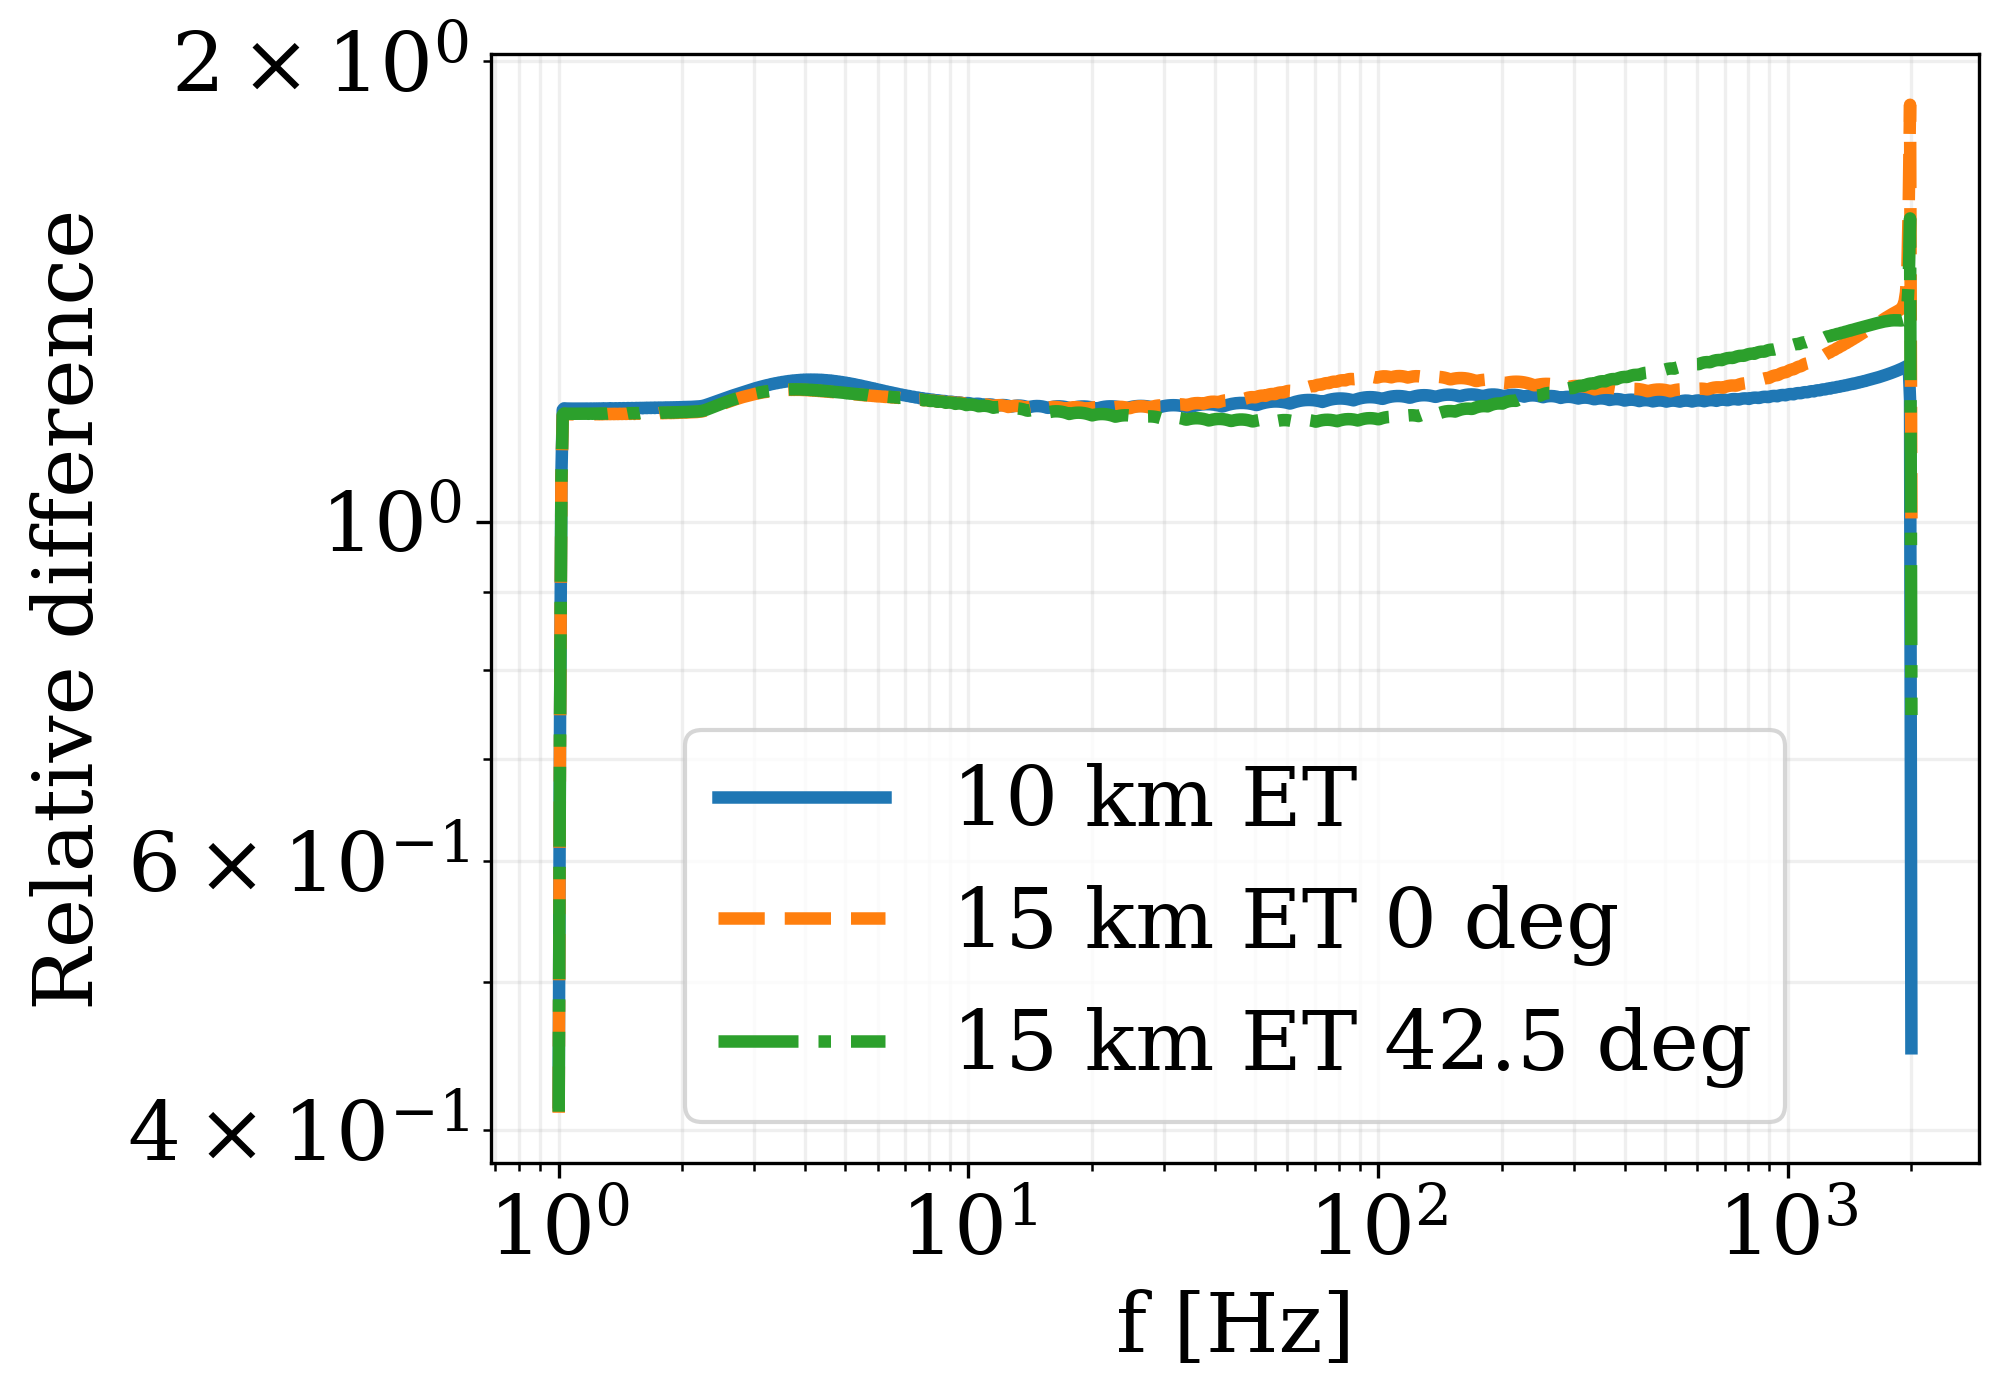

In [24]:
plt.plot(f, np.abs(diff1), label='10 km ET')
plt.plot(f, np.abs(diff2), label='15 km ET 0 deg', linestyle='--')  
plt.plot(f, np.abs(diff3), label='15 km ET 42.5 deg', linestyle='-.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.ylabel('Relative difference')
plt.grid(alpha=0.2, which='both')
plt.legend()


In [25]:
print(np.mean(diff1), np.mean(diff2), np.mean(diff3))
print(np.std(diff1), np.std(diff2), np.std(diff3))

1.2025130293408584 1.2189445416501734 1.2099130910875961
0.04079756636791381 0.0548985389388855 0.061855694068251615
